# PREDICTION FOR "Target" : FIRST MODELS

As first predictions for the first output feature "Target", we will test our first models by applying a cross validation and see which portion of the dataset it is the most relevant to use. 

In [29]:
#importation
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [31]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [32]:
#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Uploading the different dataset (SMOTE and original to use them according to the tested model)

In [34]:
X_train = pd.read_csv('X_train.csv', sep=',')
X_train_smote = pd.read_csv('X_train_resampled_target.csv', sep=',')
#for XGBoost prediction
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]
X_train_smote.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]


y_train_full = pd.read_csv('y_train.csv', sep=',') #with Target AND Failure Type row
y_train = y_train_full['Target'] #just with Target row
y_train_resampled = pd.read_csv('y_train_resampled_target.csv', sep=',')
y_train_smote = y_train_resampled['Target']

In [35]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
7973    0
7974    0
7975    1
7976    0
7977    0
Name: Target, Length: 7978, dtype: int64

To define our pipeline, we took into account two cases: whether it use smote or original dataset. 

And we choose to apply a StandardScaler only when it is necessary, this means for the models using distances, standards, or gradients that are highly sensitive to scale.

Note: for each tree based model, as we use the original dataset, to avoid problem due to the imbalance, we add a parameter like class_weight

Note 2: for models using dependency between columns and which need their names, we add a function which put the name of the column from X_train dataset in the pipeline for the models.

In [39]:
def restore_cols(X):
    return pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])

In [47]:
#stocking our different pipelines in a dict: first, the models using smote dataset
pipelines_smote = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500)) #500 because 100 was not enough to converge
    ]),
    
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC())
    ]),
    
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5)) #default value
    ]),
    
    "Neural Network (MLP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64, 32),
                              max_iter=500)) #to have as much iteration as for logistic regression
    ])
}

#weight class for CatBoost preidiction:
counts = np.bincount(y_train) 
total = len(y_train)
n_classes = len(counts)
class_weigth_catboost = [total / (n_classes * c) if c != 0 else 1.0 for c in counts]

#weight class ratio for XGBoost
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
ratio = num_neg / num_pos

#stocking our different pipelines in a second dict: the models using original datase
pipelines = {
    "DecisionTree": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", DecisionTreeClassifier(class_weight='balanced'))#compensate with imbalanced dataset
    ]),

    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", RandomForestClassifier(
            class_weight='balanced',#compensate with imbalanced dataset
            n_estimators=300, #more than the default value
        ))
    ]),

    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=6,
            scale_pos_weight=ratio, #compensate with imbalanced dataset
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            tree_method="hist"   #found to be the more optimal parameters here
        ))
    ]),

    "CatBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.05,
            verbose=None,
            class_weights=class_weigth_catboost,
            logging_level="Silent"

        ))
    ]),

    "LightGBM": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05, #more precise learning than 0.1
            max_depth=-1, #so that we don't set a limit
            subsample=0.8, #avoid overfitting
            colsample_bytree=0.8, #avoid overfitting 
            verbose=-1,
            class_weight='balanced'
        ))
    ])
}

To evaluate each model, we will apply a Stratified Cross-Validation. To check for the stability of the models and see if their accuracy changes, we choose multiple values for k : 3, 5 then 10.

In [49]:
n_values = [3, 5]

In [51]:
results = [] #stocking the results to print them

#call pipeline with different models and evaluating them
for name, model in pipelines_smote.items():
    print(f"\n{name} :")
    for n in n_values:
        k = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
        print(f"With {n} splits in Stratified k-Fold:")
        
        acc_scores = []
        prec_scores = []
        rec_scores = []
        f1_scores = []
        auc_scores = []
        for train_index, val_index in k.split(X_train_smote, y_train_smote):
            X_tr, X_val = X_train_smote.iloc[train_index], X_train_smote.iloc[val_index]
            y_tr, y_val = y_train_smote.iloc[train_index], y_train_smote.iloc[val_index]
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            if hasattr(model, "predict_proba"): #only for the models that compute probability
                y_proba = model.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_proba)
            else:
                auc = np.nan  
            acc_scores.append(accuracy_score(y_val, y_pred))
            prec_scores.append(precision_score(y_val, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_val, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
            auc_scores.append(auc)
            
        mean_acc = np.mean(acc_scores)
        mean_prec = np.mean(prec_scores)
        mean_rec = np.mean(rec_scores)
        mean_f1 = np.mean(f1_scores)
        mean_auc = np.mean(auc_scores)

        print(f"Accuracy   : {mean_acc:.4f}")
        print(f"Precision  : {mean_prec:.4f}")
        print(f"Recall     : {mean_rec:.4f}")
        print(f"F1-score   : {mean_f1:.4f}")
        print(f"AUC-score  : {mean_auc:.4f}")
        results.append({
            "Model": name,
            "k": n,
            "Accuracy": mean_acc,
            "Precision": mean_prec,
            "Recall": mean_rec,
            "F1": mean_f1,
            "AUC": mean_auc
        })

for name, model in pipelines.items():
    print(f"\n{name} :")
    for n in n_values:
        k = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
        print(f"With {n} splits in Stratified k-Fold:")
        acc_scores = []
        prec_scores = []
        rec_scores = []
        f1_scores = []
        auc_scores = []
        for train_index, val_index in k.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            if hasattr(model, "predict_proba"): #only if we obtain a proba
                y_proba = model.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_proba)
            else:
                auc = np.nan  
                
            acc_scores.append(accuracy_score(y_val, y_pred))
            prec_scores.append(precision_score(y_val, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_val, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
            auc_scores.append(auc)
            
        mean_acc = np.mean(acc_scores)
        mean_prec = np.mean(prec_scores)
        mean_rec = np.mean(rec_scores)
        mean_f1 = np.mean(f1_scores)
        mean_auc = np.mean(auc_scores)

        print(f"Accuracy   : {mean_acc:.4f}")
        print(f"Precision  : {mean_prec:.4f}")
        print(f"Recall     : {mean_rec:.4f}")
        print(f"F1-score   : {mean_f1:.4f}")
        print(f"AUC-score  : {mean_auc:.4f}")
        results.append({
            "Model": name,
            "k": n,
            "Accuracy": mean_acc,
            "Precision": mean_prec,
            "Recall": mean_rec,
            "F1": mean_f1,
            "AUC": mean_auc
        })
        


Logistic Regression :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.8347
Precision  : 0.8317
Recall     : 0.8392
F1-score   : 0.8354
AUC-score  : 0.9172
With 5 splits in Stratified k-Fold:
Accuracy   : 0.8339
Precision  : 0.8309
Recall     : 0.8385
F1-score   : 0.8347
AUC-score  : 0.9172

SVM :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.9488
Precision  : 0.9195
Recall     : 0.9838
F1-score   : 0.9505
AUC-score  : nan
With 5 splits in Stratified k-Fold:
Accuracy   : 0.9496
Precision  : 0.9193
Recall     : 0.9857
F1-score   : 0.9514
AUC-score  : nan

KNN :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.9561
Precision  : 0.9271
Recall     : 0.9900
F1-score   : 0.9575
AUC-score  : 0.9831
With 5 splits in Stratified k-Fold:
Accuracy   : 0.9583
Precision  : 0.9301
Recall     : 0.9910
F1-score   : 0.9596
AUC-score  : 0.9850

Neural Network (MLP) :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.9696
Precision  : 0.9508
Recall     : 0.9905
F1-score   : 0.9703
AUC-score  : 

Final comparison of each model based on their Recall value for each value of k fold:

In [59]:
results

[{'Model': 'Logistic Regression',
  'k': StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
  'Accuracy': 0.8346957311534968,
  'Precision': 0.8316699656252607,
  'Recall': 0.8392370572207085,
  'F1': 0.8354261744449306,
  'AUC': 0.9172248308183685},
 {'Model': 'Logistic Regression',
  'k': StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
  'Accuracy': 0.8339171942681212,
  'Precision': 0.8309201927306094,
  'Recall': 0.8384597903731217,
  'F1': 0.8346644330594077,
  'AUC': 0.9171558664581607},
 {'Model': 'SVM',
  'k': StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
  'Accuracy': 0.9488127676138576,
  'Precision': 0.9194991911893932,
  'Recall': 0.983780978331387,
  'F1': 0.9505472919874882,
  'AUC': nan},
 {'Model': 'SVM',
  'k': StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
  'Accuracy': 0.9495910777382741,
  'Precision': 0.9193234312532661,
  'Recall': 0.9857275119917247,
  'F1': 0.9513567889315906,
  'AUC': nan},
 {'Model': 'KNN',
  'k'

In [57]:
results_df = pd.DataFrame(results)
results_df['k']=[3,5,3,5,3,5,3,5,3,5,3,5,3,5,3,5,3,5]
print(results_df)

                   Model  k  Accuracy  Precision    Recall        F1       AUC
0    Logistic Regression  3  0.834696   0.831670  0.839237  0.835426  0.917225
1    Logistic Regression  5  0.833917   0.830920  0.838460  0.834664  0.917156
2                    SVM  3  0.948813   0.919499  0.983781  0.950547       NaN
3                    SVM  5  0.949591   0.919323  0.985728  0.951357       NaN
4                    KNN  3  0.956079   0.927103  0.990009  0.957522  0.983076
5                    KNN  5  0.958285   0.930119  0.991047  0.959613  0.985013
6   Neural Network (MLP)  3  0.969638   0.950809  0.990528  0.970259  0.993739
7   Neural Network (MLP)  5  0.973595   0.963236  0.984819  0.973893  0.994111
8           DecisionTree  3  0.975308   0.664024  0.579446  0.616290  0.784339
9           DecisionTree  5  0.974178   0.629976  0.583098  0.605117  0.785515
10          RandomForest  3  0.978942   0.880885  0.439398  0.584577  0.973492
11          RandomForest  5  0.981073   0.899124  0.

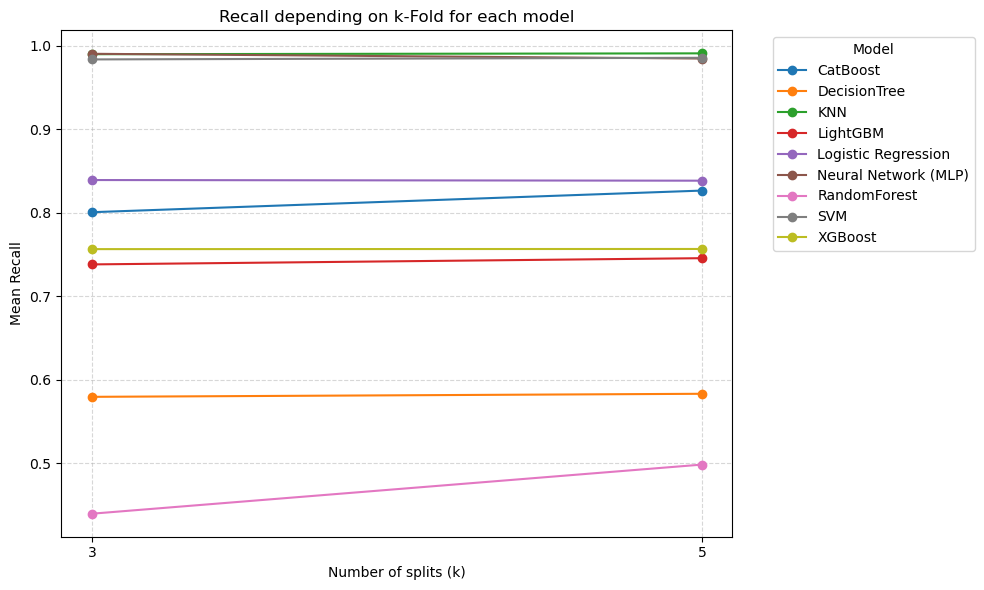

In [61]:
pivot_df = results_df.pivot(index="k", columns="Model", values="Recall")

plt.figure(figsize=(10, 6))

for model in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[model],
        marker="o",
        label=model
    )

plt.title("Recall depending on k-Fold for each model")
plt.xlabel("Number of splits (k)")
plt.ylabel("Mean Recall")
plt.xticks(pivot_df.index)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Analysis of the results : 

To conclude, the most accurate models for our prediction of "Target" are ...

Now, we will try to combine them into bagging and ensemble model to be more accurate and precise (in the next notebook) to converge toward a final model.